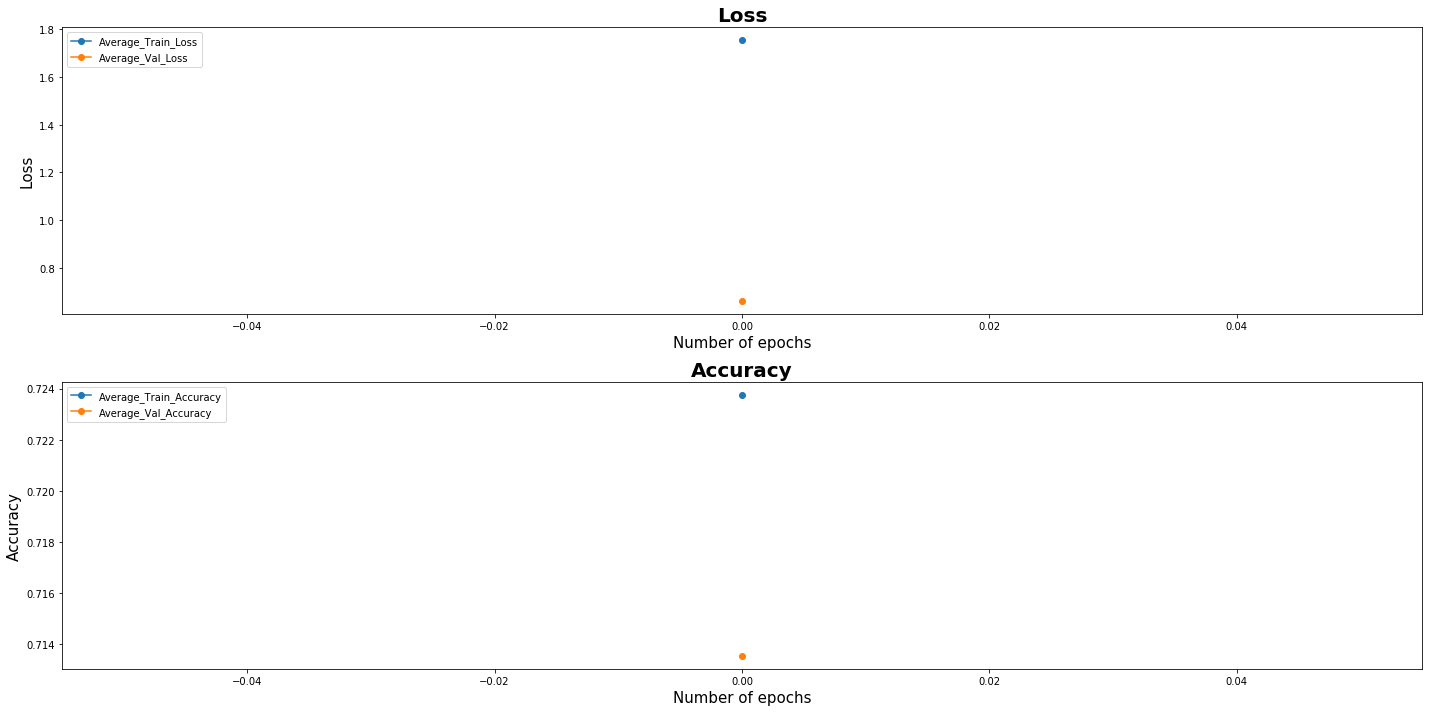

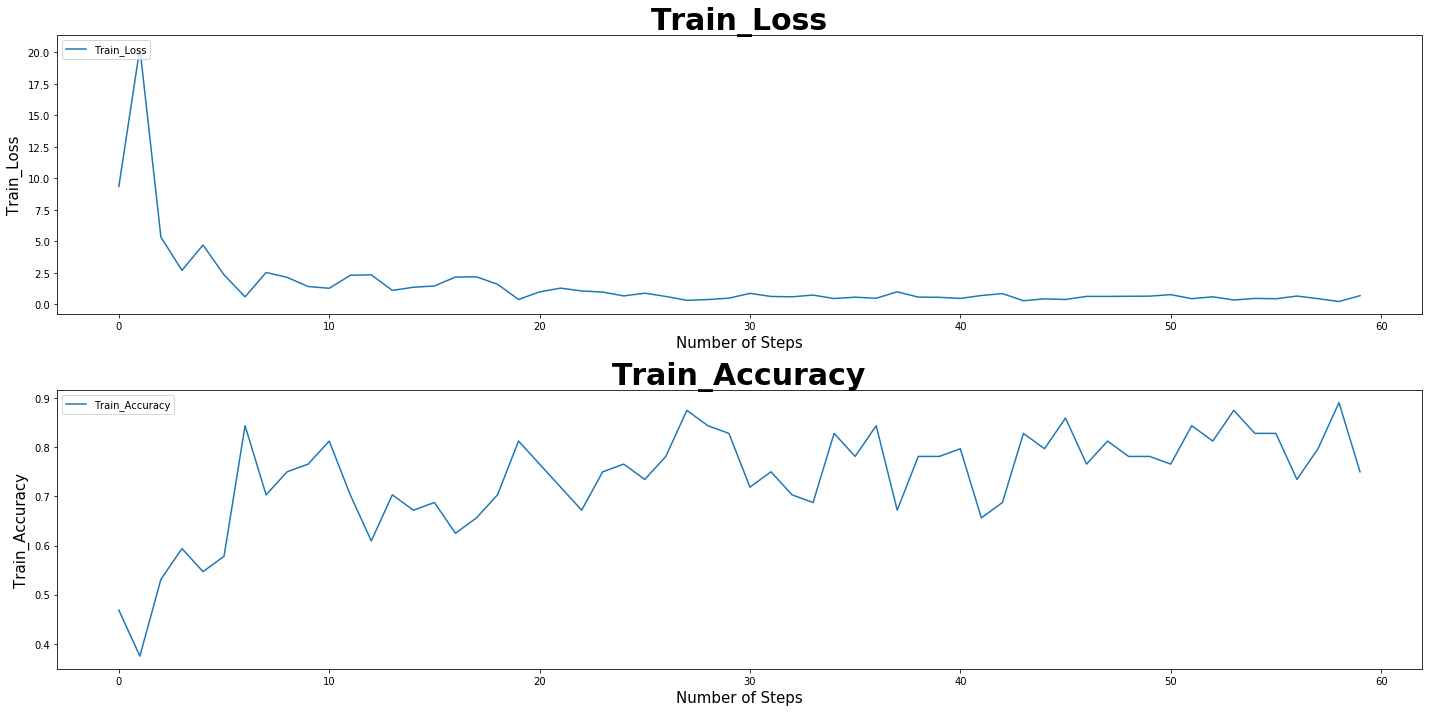

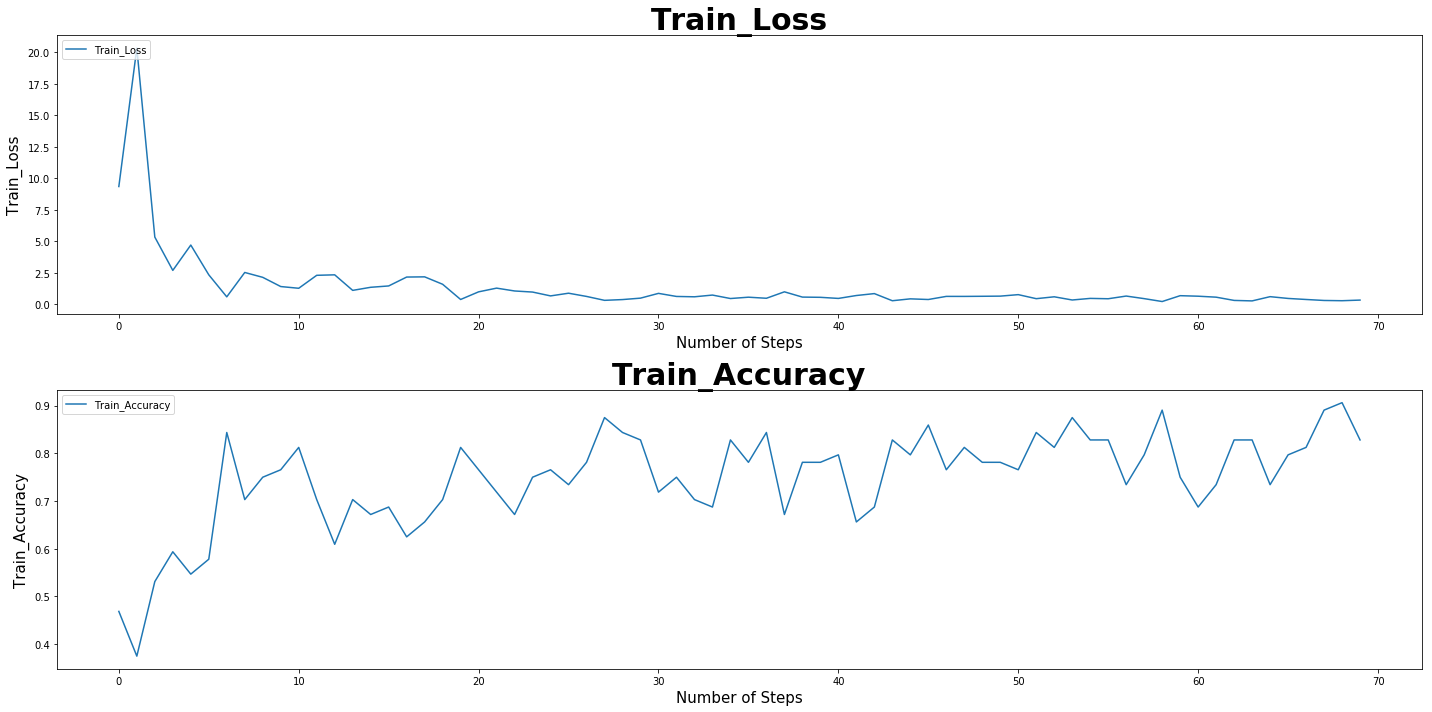

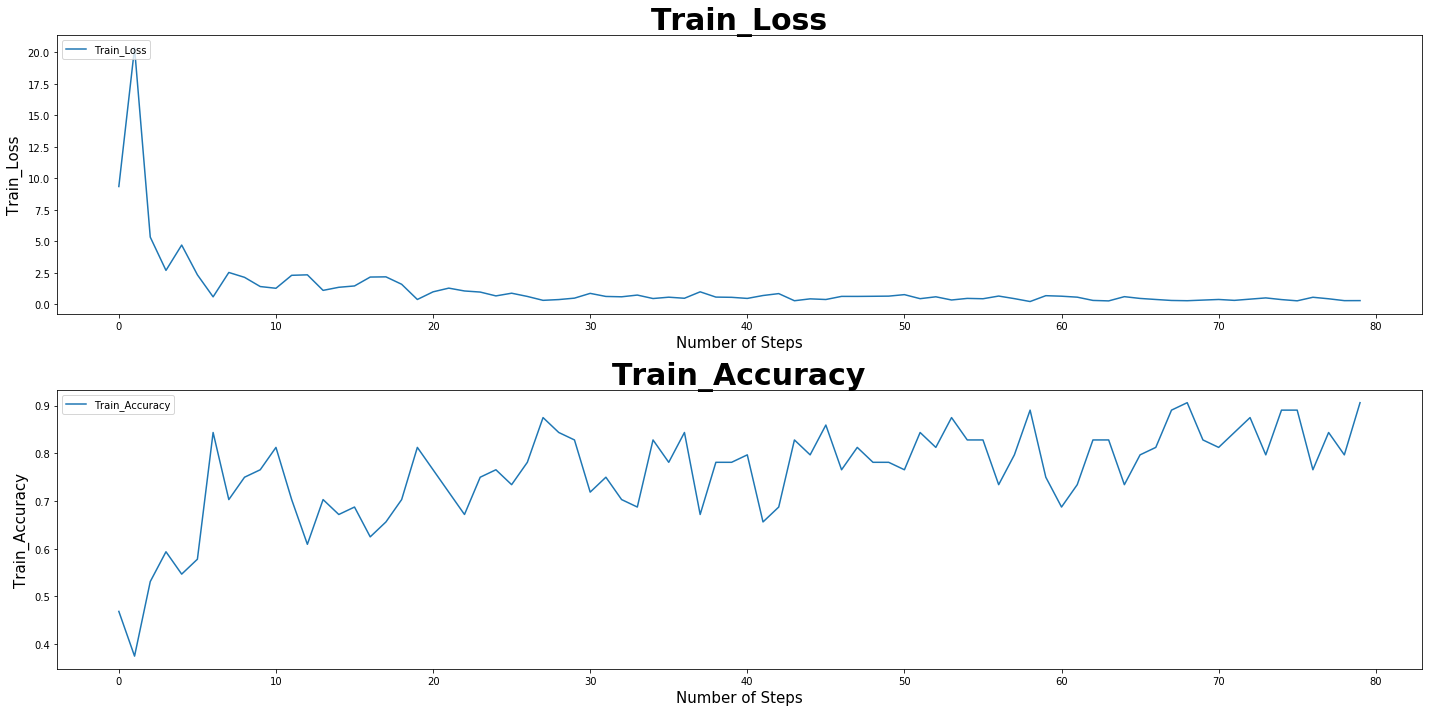

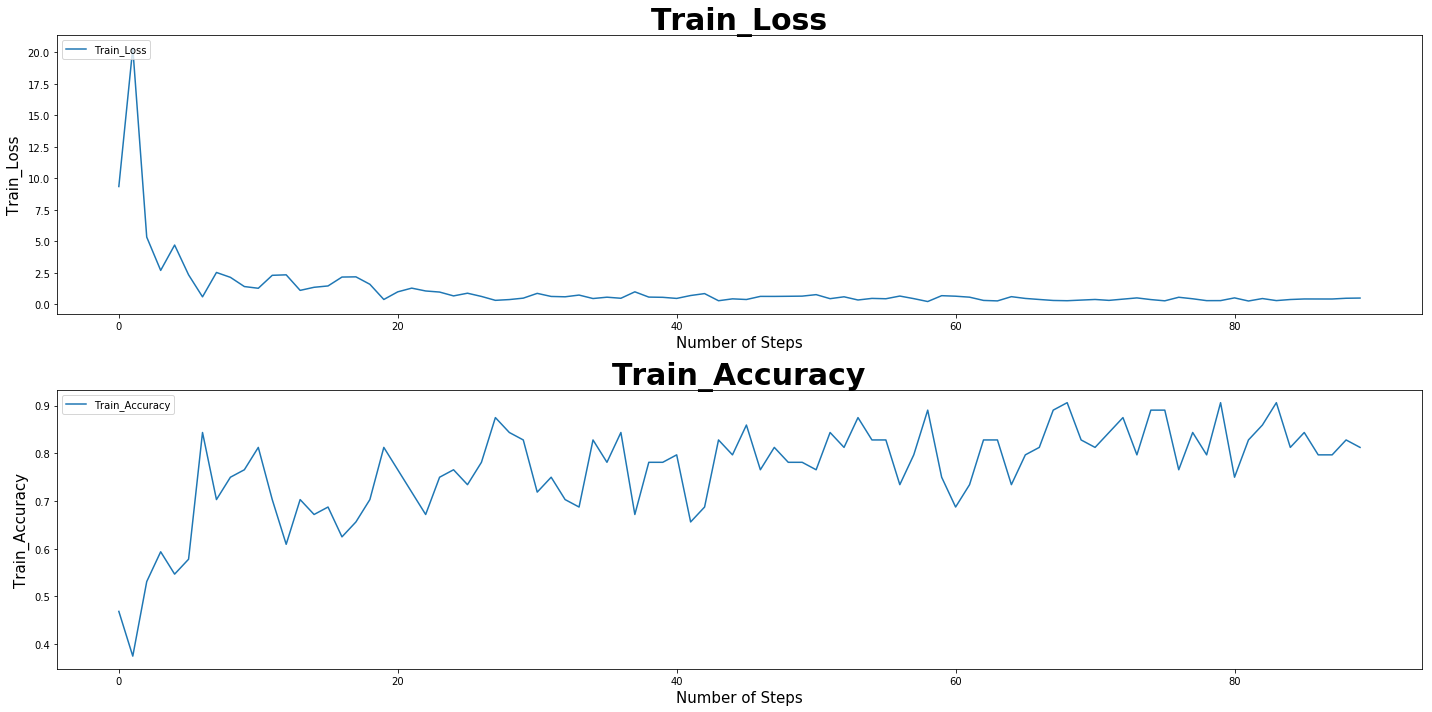

Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.6/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-7-285422b9bdea>", line 520, in StartTraining
    trainer.plot_train_hist(args.model_name)
  File "/home/chihcheng/Desktop/NewSpamDectionProject/Trainers.py", line 272, in plot_train_hist
    return self.loss, self.accuracy, self.cm
  File "/home/chihcheng/python3env/lib/python3.6/site-packages/matplotlib/pyplot.py", line 254, in show
    return _show(*args, **kw)
  File "/home/chihcheng/python3env/lib/python3.6/site-packages/ipykernel/pylab/backend_inline.py", line 39, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "/home/chihcheng/python3env/lib/python3.6/site-packages/IPython/core/display.py", line 304, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/chihcheng/python3env/lib/python3.6/site-packages/IPython/core/forma

In [7]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from urllib.parse import urlparse
import os
import numpy as np
from IPython.display import clear_output, display
import time
import pandas as pd

from Constants import Constants, specialTokenList, specialTokens
from All_Models import SSCL, GatedCNN, SelfAttnModel
from utils import getSampler
from Trainers import Trainer, TkTrainer
from LoadData import loadingData, TkloadingData
import tkinter as tk


class args(object):

    # Data

    dataset = ["HSpam14", "Honeypot"][1]
    full_data = True
    usingWeightRandomSampling = True
    vocab_size = 8000  # if we create the new vocab size, we have to do the new preprocess again
    validation_portion = 0.05
    test_portion = 0.04

    pickle_name = "FullPickleData" + str(vocab_size) + "Vocab.txt"
    pickle_name_beforeMapToIdx = "FullPickleDatabeforeMapToIdx.txt"

    # Arch

    # GatedCNN arch

    GatedCNN_embedingDim = 128
    GatedCNN_convDim = 64
    GatedCNN_kernel = 3
    GatedCNN_stride = 1
    GatedCNN_pad = 1
    GatedCNN_layers = 8
    GatedCNN_dropout = 0.1

    # SSCL arch

    SSCL_embedingDim = 512
    SSCL_RNNHidden = 256
    SSCL_CNNDim = 256
    SSCL_CNNKernel = 5
    SSCL_CNNDropout = 0.1
    SSCL_LSTMDropout = 0.1
    SSCL_LSTMLayers = 1

    # Attn arch

    SelfAttn_LenMaxSeq = 280  # Default, will be changed Later

    # These Two has to be the same
    SelfAttn_WordVecDim = 128
    SelfAttn_ModelDim = 128

    SelfAttn_FFInnerDim = 256
    SelfAttn_NumLayers = 3
    SelfAttn_NumHead = 4
    SelfAttn_KDim = 64
    SelfAttn_VDim = 64
    SelfAttn_Dropout = 0.1

    # Training params

    batch_size = 64
    L2 = 0.1
    threshold = 0.5
    lr = 0.002
    n_epoch = 50

    # If using Adam
    adam_beta1 = 0.9
    adam_beta2 = 0.999

    earlyStopStep = 5000 # Set None if we don't want it
    earlyStopEpoch = 1

    # Logging the Training
    val_freq = 50
    val_steps = 3
    log_freq = 10
    model_save_freq = 1
    model_name = 'SpamDetectionModel'
    model_path = './' + dataset + '_Log/' + model_name + '/Model/'
    log_path = './' + dataset + '_Log/' + model_name + '/Log/'


window = tk.Tk()
window.title('Spammer Detection')
window.geometry('1920x1280')


def setBoolHyerParams(window, var, text, x, y):
    c = tk.Checkbutton(window, text=text,
                       onvalue=True, offvalue=False, variable=var)
    c.place(x=x, y=y, anchor='nw')


def setHyperPrams(window, text, x, y):
    l = tk.Label(window,
                 text=text,    # 标签的文字
                 font=('Arial', 12),     # 字体和字体大小 # 标签长宽
                 )
    l.place(x=x, y=y, anchor='nw')
    e = tk.Entry(window)
    e.place(x=(x+200), y=y, anchor="nw")
    return l, e


def setRadioButtons(var, label, texts, values, command, x, y):

    l = tk.Label(window,
                 text=label,
                 font=('Arial', 12),
                 )
    l.place(x=x, y=y, anchor='nw')

    for t, v in zip(texts, values):
        y = y+40
        tk.Radiobutton(window, text=t, font=('Arial', 12),
                       variable=var, value=v,
                       command=command,).place(x=x, y=y, anchor='nw')


############### Dataset ###############

def Take_DatasetSelection():
    print("Selected Dataset: ", datasetSelected.get())


datasetSelected = tk.StringVar()

setRadioButtons(datasetSelected, "Dataset:",
                ["HSpam14Dataset", "HoneypotDataset"], ['HSpam14', 'Honeypot'],
                Take_DatasetSelection, 10, 10)


############### Models ###############


def Take_ModelSelection():
    printHyperParamsSetting(window, modelSelected.get(), 250, 10)


modelSelected = tk.StringVar()

models_list = ['SSCL', 'GatedCNN', 'SelfAttn']

setRadioButtons(modelSelected, "Model:", models_list,
                models_list, Take_ModelSelection, 10, 150)


x = 250
y = 10


GatedCNN_embedingDim_label, GatedCNN_embedingDim = setHyperPrams(
    window, "GatedCNN_embedingDim", x, y)
GatedCNN_convDim_label, GatedCNN_convDim = setHyperPrams(
    window, "GatedCNN_convDim", x, y+(30*1))
GatedCNN_kernel_label, GatedCNN_kernel = setHyperPrams(
    window, "GatedCNN_kernel", x, y+(30*2))
GatedCNN_stride_label, GatedCNN_stride = setHyperPrams(
    window, "GatedCNN_stride", x, y+(30*3))
GatedCNN_pad_label, GatedCNN_pad = setHyperPrams(
    window, "GatedCNN_pad", x, y+(30*4))
GatedCNN_layers_label, GatedCNN_layers = setHyperPrams(
    window, "GatedCNN_layers", x, y+(30*5))
GatedCNN_dropout_label, GatedCNN_dropout = setHyperPrams(
    window, "GatedCNN_dropout", x, y+(30*6))

SSCL_RNNHidden_label, SSCL_RNNHidden = setHyperPrams(
    window, "SSCL_RNNHidden", x, y)
SSCL_CNNDim_label, SSCL_CNNDim = setHyperPrams(
    window, "SSCL_CNNDim", x, y+(30*1))
SSCL_CNNKernel_label, SSCL_CNNKernel = setHyperPrams(
    window, "SSCL_CNNKernel", x, y+(30*2))
SSCL_CNNDropout_label, SSCL_CNNDropout = setHyperPrams(
    window, "SSCL_CNNDropout", x, y+(30*3))
SSCL_LSTMDropout_label, SSCL_LSTMDropout = setHyperPrams(
    window, "SSCL_LSTMDropout", x, y+(30*4))
SSCL_LSTMLayers_label, SSCL_LSTMLayers = setHyperPrams(
    window, "SSCL_LSTMLayers", x, y+(30*5))
SSCL_embedingDim_label, SSCL_embedingDim = setHyperPrams(
    window, "SSCL_embedingDim", x, y+(30*6))

SelfAttn_LenMaxSeq_label, SelfAttn_LenMaxSeq = setHyperPrams(
    window, "SelfAttn_LenMaxSeq", x, y)
SelfAttn_ModelDim_label, SelfAttn_ModelDim = setHyperPrams(
    window, "SelfAttn_ModelDim", x, y+(30*1))
SelfAttn_FFInnerDim_label, SelfAttn_FFInnerDim = setHyperPrams(
    window, "SelfAttn_FFInnerDim", x, y+(30*2))
SelfAttn_NumLayers_label, SelfAttn_NumLayers = setHyperPrams(
    window, "SelfAttn_NumLayers", x, y+(30*3))
SelfAttn_NumHead_label, SelfAttn_NumHead = setHyperPrams(
    window, "SelfAttn_NumHead", x, y+(30*4))
SelfAttn_KDim_label, SelfAttn_KDim = setHyperPrams(
    window, "SelfAttn_KDim", x, y+(30*5))
SelfAttn_VDim_label, SelfAttn_VDim = setHyperPrams(
    window, "SelfAttn_VDim", x, y+(30*6))
SelfAttn_Dropout_label, SelfAttn_Dropout = setHyperPrams(
    window, "SelfAttn_Dropout", x, y+(30*7))

GatedCNN_label = [
    GatedCNN_embedingDim_label,
    GatedCNN_convDim_label,
    GatedCNN_kernel_label,
    GatedCNN_stride_label,
    GatedCNN_pad_label,
    GatedCNN_layers_label,
    GatedCNN_dropout_label,
]

GatedCNN_entry = [
    GatedCNN_embedingDim,
    GatedCNN_convDim,
    GatedCNN_kernel,
    GatedCNN_stride,
    GatedCNN_pad,
    GatedCNN_layers,
    GatedCNN_dropout,
]

SSCL_label = [
    SSCL_RNNHidden_label,
    SSCL_CNNDim_label,
    SSCL_CNNKernel_label,
    SSCL_CNNDropout_label,
    SSCL_LSTMDropout_label,
    SSCL_LSTMLayers_label,
    SSCL_embedingDim_label
]

SSCL_entry = [
    SSCL_RNNHidden,
    SSCL_CNNDim,
    SSCL_CNNKernel,
    SSCL_CNNDropout,
    SSCL_LSTMDropout,
    SSCL_LSTMLayers,
    SSCL_embedingDim,
]


SelfAttn_label = [
    SelfAttn_LenMaxSeq_label,
    SelfAttn_ModelDim_label,
    SelfAttn_FFInnerDim_label,
    SelfAttn_NumLayers_label,
    SelfAttn_NumHead_label,
    SelfAttn_KDim_label,
    SelfAttn_VDim_label,
    SelfAttn_Dropout_label,
]

SelfAttn_entry = [

    SelfAttn_LenMaxSeq,
    SelfAttn_ModelDim,
    SelfAttn_FFInnerDim,
    SelfAttn_NumLayers,
    SelfAttn_NumHead,
    SelfAttn_KDim,
    SelfAttn_VDim,
    SelfAttn_Dropout,
]


def forgetLabelAndEntry(label, entry):
    for l, e in zip(label, entry):
        l.place_forget()
        e.place_forget()


forgetLabelAndEntry(SSCL_label, SSCL_entry)
forgetLabelAndEntry(SelfAttn_label, SelfAttn_entry)
forgetLabelAndEntry(GatedCNN_label, GatedCNN_entry)


def placeLabelAndEntry(labels, entries, x, y):
    for l, e in zip(labels, entries):
        y = y + 30
        l.place(x=x, y=y, anchor='nw')
        e.place(x=(x+250), y=y, anchor="nw")


def printHyperParamsSetting(window, model, x, y):

    x = 250
    y = 10

    if model == 'GatedCNN':

        forgetLabelAndEntry(SSCL_label, SSCL_entry)
        forgetLabelAndEntry(SelfAttn_label, SelfAttn_entry)
        placeLabelAndEntry(GatedCNN_label, GatedCNN_entry, x, y)

    elif model == "SSCL":

        # Have to fix this part in the SSCL Model

        forgetLabelAndEntry(GatedCNN_label, GatedCNN_entry)
        forgetLabelAndEntry(SelfAttn_label, SelfAttn_entry)
        placeLabelAndEntry(SSCL_label, SSCL_entry, x, y)

    elif model == "SelfAttn":

        forgetLabelAndEntry(GatedCNN_label, GatedCNN_entry)
        forgetLabelAndEntry(SSCL_label, SSCL_entry)
        placeLabelAndEntry(SelfAttn_label, SelfAttn_entry, x, y)

    else:
        raise ValueError


x = 770
y = 30

vocab_size_label, vocab_size = setHyperPrams(window, "vocab_size", x, y)
validation_portion_label, validation_portion = setHyperPrams(
    window, "validation_portion", x, (y+(30*1)))
test_portion_label, test_portion = setHyperPrams(
    window, "test_portion", x, (y+(30*2)))
batch_size_label, batch_size = setHyperPrams(
    window, "batch_size", x, (y+(30*3)))
L2_label, L2 = setHyperPrams(window, "L2", x, (y+(30*4)))
lr_label, lr = setHyperPrams(window, "lr", x, (y+(30*5)))
n_epoch_label, n_epoch = setHyperPrams(window, "n_epoch", x, (y+(30*6)))
earlyStopStep_label, earlyStopStep = setHyperPrams(
    window, "earlyStopStep", x, (y+(30*7)))
earlyStopEpoch_label, earlyStopEpoch = setHyperPrams(
    window, "earlyStopEpoch", x, (y+(30*8)))
val_freq_label, val_freq = setHyperPrams(window, "val_freq", x, (y+(30*9)))
val_steps_label, val_steps = setHyperPrams(window, "val_steps", x, (y+(30*10)))
log_freq_label, log_freq = setHyperPrams(window, "log_freq", x, (y+(30*11)))
model_name_label, model_name = setHyperPrams(
    window, "model_name", x, (y+(30*12)))

usingWeightRandomSampling = tk.StringVar()
setBoolHyerParams(window, usingWeightRandomSampling,
                  "usingWeightRandomSampling", x, (y+(30*14)))


resultTextbox = tk.Text(window, height = 25, width = 90)
resultTextbox.place(x=40, y=500, anchor='nw')


vocab_size.insert("end", args.vocab_size)
validation_portion.insert("end", args.validation_portion)
test_portion.insert("end", args.test_portion)
batch_size.insert("end", args.batch_size)
L2.insert("end", args.L2)
lr.insert("end", args.lr)
n_epoch.insert("end", args.n_epoch)
earlyStopStep.insert("end", args.earlyStopStep)
earlyStopEpoch.insert("end", args.earlyStopEpoch)
val_freq.insert("end", args.val_freq)
val_steps.insert("end", args.val_steps)
log_freq.insert("end", args.log_freq)
GatedCNN_embedingDim.insert("end", args.GatedCNN_embedingDim)
GatedCNN_convDim.insert("end", args.GatedCNN_convDim)
GatedCNN_kernel.insert("end", args.GatedCNN_kernel)
GatedCNN_stride.insert("end", args.GatedCNN_stride)
GatedCNN_pad.insert("end", args.GatedCNN_pad)
GatedCNN_layers.insert("end", args.GatedCNN_layers)
GatedCNN_dropout.insert("end", args.GatedCNN_dropout)
SSCL_embedingDim.insert("end", args.SSCL_embedingDim)
SSCL_RNNHidden.insert("end", args.SSCL_RNNHidden)
SSCL_CNNDim.insert("end", args.SSCL_CNNDim)
SSCL_CNNKernel.insert("end", args.SSCL_CNNKernel)
SSCL_CNNDropout.insert("end", args.SSCL_CNNDropout)
SSCL_LSTMDropout.insert("end", args.SSCL_LSTMDropout)
SSCL_LSTMLayers.insert("end", args.SSCL_LSTMLayers)
SelfAttn_LenMaxSeq.insert("end", args.SelfAttn_LenMaxSeq)
SelfAttn_ModelDim.insert("end", args.SelfAttn_ModelDim)
SelfAttn_FFInnerDim.insert("end", args.SelfAttn_FFInnerDim)
SelfAttn_NumLayers.insert("end", args.SelfAttn_NumLayers)
SelfAttn_NumHead.insert("end", args.SelfAttn_NumHead)
SelfAttn_KDim.insert("end", args.SelfAttn_KDim)
SelfAttn_VDim.insert("end", args.SelfAttn_VDim)
SelfAttn_Dropout.insert("end", args.SelfAttn_Dropout)

    

def StartTraining():
    
    
    resultTextbox.insert("end", "Training Start\n")
    window.update_idletasks()
    
    
    ##### Init Args
    
    args.vocab_size = int(vocab_size.get())
    args.validation_portion = float(validation_portion.get())
    args.test_portion = float(test_portion.get())
    args.batch_size = int(batch_size.get())
    args.L2 = float(L2.get())
    args.lr = float(lr.get())
    args.n_epoch = int(n_epoch.get())
    args.earlyStopStep = int(earlyStopStep.get())
    args.earlyStopEpoch = int(earlyStopEpoch.get())
    args.val_freq = int(val_freq.get())
    args.val_steps = int(val_steps.get())
    args.log_freq = int(log_freq.get())
    args.GatedCNN_embedingDim = int(GatedCNN_embedingDim.get())
    args.GatedCNN_convDim = int(GatedCNN_convDim.get())
    args.GatedCNN_kernel = int(GatedCNN_kernel.get())
    args.GatedCNN_stride = int(GatedCNN_stride.get())
    args.GatedCNN_pad = int(GatedCNN_pad.get())
    args.GatedCNN_layers = int(GatedCNN_layers.get())
    args.GatedCNN_dropout = float(GatedCNN_dropout.get())
    args.SSCL_embedingDim = int(SSCL_embedingDim.get())
    args.SSCL_RNNHidden = int(SSCL_RNNHidden.get())
    args.SSCL_CNNDim = int(SSCL_CNNDim.get())
    args.SSCL_CNNKernel = int(SSCL_CNNKernel.get())
    args.SSCL_CNNDropout = float(SSCL_CNNDropout.get())
    args.SSCL_LSTMDropout = float(SSCL_LSTMDropout.get())
    args.SSCL_LSTMLayers = int(SSCL_LSTMLayers.get())
    args.SelfAttn_LenMaxSeq = int(SelfAttn_LenMaxSeq.get())
    args.SelfAttn_ModelDim = int(SelfAttn_ModelDim.get())
    args.SelfAttn_FFInnerDim = int(SelfAttn_FFInnerDim.get())
    args.SelfAttn_NumLayers = int(SelfAttn_NumLayers.get())
    args.SelfAttn_NumHead = int(SelfAttn_NumHead.get())
    args.SelfAttn_KDim = int(SelfAttn_KDim.get())
    args.SelfAttn_VDim = int(SelfAttn_VDim.get())
    args.SelfAttn_Dropout = float(SelfAttn_Dropout.get())
    

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    args.device = device
    
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)

    if not os.path.exists(args.log_path):
        os.makedirs(args.log_path)
        
    training_dataset, validation_dataset, test_dataset, text = TkloadingData(args, resultTextbox, window)
    
    args.numberOfSpammer = sum([t[-1] for t in training_dataset])
    args.numberOfNonSpammer = len(training_dataset)-args.numberOfSpammer
    args.len_max_seq = training_dataset[0][2]

    resultTextbox.insert("end", ("Number of Spammer: " +str(args.numberOfSpammer.item()) +"\n" ))
    resultTextbox.insert("end", ("Number of NonSpammer: " + str(args.numberOfNonSpammer.item()) +"\n" ))
    window.update_idletasks()
    
    if args.usingWeightRandomSampling:
        sampler = getSampler(training_dataset)
    else:
        sampler = None

    train_loader = DataLoader(
        training_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False, sampler = sampler)
    valid_loader = DataLoader(
        validation_dataset, batch_size=args.batch_size, shuffle=True, drop_last=False)

    
    if modelSelected.get() == 'SSCL':
        resultTextbox.insert("end", "Using SSCL\n")
        trainModel = SSCL
    elif modelSelected.get() == 'GatedCNN':
        resultTextbox.insert("end", "Using GatedCNN\n")
        trainModel = GatedCNN
    elif modelSelected.get() == 'SelfAttn':
        resultTextbox.insert("end", "Using SelfAttn\n")
        trainModel = SelfAttnModel
    else:
        resultTextbox.insert("end", 'No Support For this Model')
        raise ValueError
        
    window.update_idletasks()
    
    trainer = TkTrainer(trainModel, args, resultTextbox, window).to(device)
                             
    resultTextbox.insert("end", ("Number of Parameters in this Model: " + str(trainer.num_all_params()) +"\n"))
    resultTextbox.insert("end", ("Using device: " + str(device) +"\n"))
    window.update_idletasks()
    
    scheduler = optim.lr_scheduler.StepLR(trainer.optim, 2000, gamma=0.85)
    # trainer.optim.param_groups[0]['lr']=
    allStep = 0
    epoch = 0
    
    resultTextbox.insert("end",("Model Structure: \n" + str(trainer.model) + "\n"))
    
    window.update_idletasks()
    
    while epoch < args.n_epoch:
        for i, (texts, X , X_len, y) in enumerate(train_loader):

            trainer.train()
            X, X_len, y = X.to(device), X_len.to(device), y.to(device)

            if trainer.optim.param_groups[0]['lr'] >= 0.00001:
                scheduler.step()
            start_t = time.time()
    #         trainer.train_step((X, X_len), y)
            trainer.train_step(X, y)

            end_t = time.time()
            allStep += 1
            resultTextbox.insert("end", ('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs \n' %
                  (epoch, allStep, trainer.optim.param_groups[0]['lr'], trainer.loss.item(), trainer.accuracy.item(),
                   end_t - start_t)))
            window.update_idletasks()
            
    #         if trainer.accuracy.item() > 0.95: # Stop early
    #             raise StopIteration
            if allStep % args.log_freq == 0:
                trainer.plot_train_hist(args.model_name)


            if args.earlyStopStep:
                if allStep >= args.earlyStopStep:
                        raise StopIteration


            if allStep % args.val_freq == 0:

                for _ in range(args.val_steps):
                    trainer.eval()
                    stIdx = np.random.randint(
                        0, len(validation_dataset) - args.batch_size)
                    v_text, v_X, v_X_len, v_y = validation_dataset[stIdx: stIdx +
                                                           args.batch_size]
                    v_X, v_X_len, v_y = v_X.to(
                        device), v_X_len.to(device), v_y.to(device)
                    start_t = time.time()
    #                 trainer.test_step((v_X, v_X_len), v_y)
                    trainer.test_step(v_X, v_y)
                    end_t = time.time()
                    resultTextbox.insert("end", ('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs \n' %
                          (epoch, allStep, trainer.loss.item(), trainer.accuracy.item(), end_t - start_t)))
                    window.update_idletasks()
                    
                trainer.calculateAverage()
                clear_output()
                resultTextbox.insert("end",("TrainConfusion Matrix: \n"))
                resultTextbox.insert("end",pd.DataFrame(trainer.cms['Train'][-1]))
                resultTextbox.insert("end","\n\n")
                resultTextbox.insert("end",("ValidationConfusion Matrix: \n"))
                resultTextbox.insert("end",trainer.cms['Val'][-1] )
                resultTextbox.insert("end","\n\n")
                window.update_idletasks()
                trainer.plot_all(args.model_name)

         # After every Epoch, if can be moved

        epoch += 1
        trainer.model_save(epoch)


        if args.earlyStopEpoch:
            if epoch >= args.earlyStopEpoch:
                raise StopIteration5000

    
    
    


StartButton = tk.Button(window,
                        text='Strat Training',
                        width=15, height=2,
                        command=StartTraining)
StartButton.place(x=1000, y=500, anchor="nw")


window.mainloop()


In [2]:
args.vocab_size

8000

In [3]:
GatedCNN_label = [
    GatedCNN_embedingDim_label,
    GatedCNN_convDim_label,
    GatedCNN_kernel_label,
    GatedCNN_stride_label,
    GatedCNN_pad_label,
    GatedCNN_layers_label,
    GatedCNN_dropout_label,
]

GatedCNN_entry = [
    GatedCNN_embedingDim,
    GatedCNN_convDim,
    GatedCNN_kernel,
    GatedCNN_stride,
    GatedCNN_pad,
    GatedCNN_layers,
    GatedCNN_dropout,
]

SSCL_label = [
    SSCL_RNNHidden_label,
    SSCL_CNNDim_label,
    SSCL_CNNKernel_label,
    SSCL_CNNDropout_label,
    SSCL_LSTMDropout_label,
    SSCL_LSTMLayers_label,

]

SSCL_entry = [
    
    SSCL_RNNHidden,
    SSCL_CNNDim,
    SSCL_CNNKernel,
    SSCL_CNNDropout,
    SSCL_LSTMDropout,
    SSCL_LSTMLayers,
]


SelfAttn_label = [
    SelfAttnLenMaxSeq_label,
    SelfAttnModelDim_label,
    SelfAttnFFInnerDim_label,
    SelfAttnNumLayers_label,
    SelfAttnNumHead_label,
    SelfAttnKDim_label,
    SelfAttnVDim_label,
    SelfAttnDropout_label,
]

SelfAttn_entry = [
    
    SelfAttnLenMaxSeq,
    SelfAttnModelDim,
    SelfAttnFFInnerDim,
    SelfAttnNumLayers,
    SelfAttnNumHead,
    SelfAttnKDim,
    SelfAttnVDim,
    SelfAttnDropout,
]

NameError: name 'SelfAttnLenMaxSeq_label' is not defined

In [ ]:
















var =  tk.StringVar() 

l = tk.Label(window, 
    textvariable=var,    # 标签的文字
    font=('Arial', 12),     # 字体和字体大小
    width=15, height=2  # 标签长宽
    )
l.pack()    # 固定窗口位置


l2 = tk.Label(window, 
    text='Text Data!',    # 标签的文字
    font=('Arial', 12),     # 字体和字体大小
    width=15, height=2  # 标签长宽
    )
l2.pack()    

b = tk.Button(window, 
    text='hit me',      # 显示在按钮上的文字
    width=15, height=2, 
    command=hit_me)     # 点击按钮式执行的命令
b.pack()    # 按钮位置




on_hit = False  # 默认初始状态为 False
def hit_me():
    global on_hit
    if on_hit == False:     # 从 False 状态变成 True 状态
        on_hit = True
        var.set('you hit me')   # 设置标签的文字为 'you hit me'
    else:       # 从 True 状态变成 False 状态
        on_hit = False
        var.set('') # 设置 文字为空


        
''' 
For Taking Input
'''        

e = tk.Entry(window)
# e = tk.Entry(window,show='*')
e.pack()
        
t = tk.Text(window,height=2)
t.pack()
        
    
var1 = tk.StringVar()    #创建变量
l =tk.Label(window,bg='yellow',width=4,textvariable=var1)
l.pack()
    
def print_selection():
    value = lb.get(lb.curselection())   #获取当前选中的文本
    var.set(value)     #为label设置值
    
    
'''
List
'''

b1 = tk.Button(window, text='print selection', width=15,
              height=2, command=print_selection)
b1.pack()
    
var2 = tk.StringVar()
var2.set((11,22,33,44)) #为变量设置值

#创建Listbox

lb = tk.Listbox(window, listvariable=var2)  #将var2的值赋给Listbox



#创建一个list并将值循环添加到Listbox控件中
# list_items = [1,2,3,4]
# for item in list_items:
#     lb.insert('end', item)  #从最后一个位置开始加入值
# lb.insert(1, 'first')       #在第一个位置加入'first'字符
# lb.insert(2, 'second')      #在第二个位置加入'second'字符
# lb.delete(2)                #删除第二个位置的字符
lb.pack()

var = tk.StringVar()
l = tk.Label(window, bg='yellow', width=20, text='empty')
l.pack()

r1 = tk.Radiobutton(window, text='Option A',
                    variable=var, value='A',
                    command=print_selection)
r1.pack()

def print_selection():
    l.config(text='you have selected ' + var.get())